데이터 출처 : https://www.kaggle.com/c/ga-customer-revenue-prediction

참고 커널
- https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
- https://www.kaggle.com/erikbruin/google-analytics-eda-lightgbm-screenshots

In [74]:
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

train 데이터의 다중 값 필드가 있어 데이터를 불러올 때 단일 값 필드로 변경합니다.

In [72]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

- 데이터 불러옵니다

In [73]:
df = load_df()

Loaded train.csv. Shape: (903653, 55)


In [75]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

- 데이터의 칼럼을 확인합니다.

In [6]:
df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.t

데모버전으로 확인할 수 없는 값을 NULL 값으로 대체합니다.
- 'not available in demo dataset' 널 (null)값으로 변경 

In [76]:
remove = ['not available in demo dataset']

In [77]:
for col in df.columns:
    df[col] = df[col].apply(lambda x : np.nan if  x in remove else x)

In [78]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,NaN,NaN,Windows,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,NaN,ttnet.com.tr,NaN,NaN,NaN,1,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,NaN,NaN,Macintosh,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desktop,Oceania,Australasia,Australia,NaN,NaN,NaN,NaN,dodo.net.au,NaN,NaN,NaN,1,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,NaN,NaN,Windows,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,NaN,unknown.unknown,NaN,NaN,NaN,1,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,NaN,NaN,Linux,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desktop,Asia,Southeast Asia,Indonesia,NaN,NaN,NaN,NaN,unknown.unknown,NaN,NaN,NaN,1,1,1,1,1,NaN,(not set),google,organic,google + online,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,NaN,NaN,Android,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,Europe,Northern Europe,United Kingdom,NaN,NaN,NaN,NaN,unknown.unknown,NaN,NaN,NaN,1,1,1,1,NaN,NaN,(not set),google,organic,(not provided),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


결측치 비율을 보여줍니다.

In [83]:
(df.isnull().sum() / len(df)) * 100

channelGrouping                                        0.000000
date                                                   0.000000
fullVisitorId                                          0.000000
sessionId                                              0.000000
socialEngagementType                                   0.000000
visitId                                                0.000000
visitNumber                                            0.000000
visitStartTime                                         0.000000
device.browser                                         0.000000
device.browserVersion                                100.000000
device.browserSize                                   100.000000
device.operatingSystem                                 0.000000
device.operatingSystemVersion                        100.000000
device.isMobile                                        0.000000
device.mobileDeviceBranding                          100.000000
device.mobileDeviceModel                

결측치 비율이 전반적으로 높습니다. 타겟값 transactionRevenue 결측치 비율도 상당히 높습니다.

### 전처리

- 1차 필터

결측치 100% 기준으로 제거할 칼럼들을 뽑아서 데이터셋에서 삭제합니다.





In [84]:
df.columns[df.isnull().sum() / len(df) == 1]

Index(['device.browserVersion', 'device.browserSize',
       'device.operatingSystemVersion', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation',
       'trafficSource.adwordsClickInfo.criteriaParameters'],
      dtype='object')

In [85]:
drop_col = df.columns[df.isnull().sum() / len(df) == 1]

In [86]:
df = df.drop(drop_col.values, axis = 1)

In [87]:
df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.operatingSystem', 'device.isMobile',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.visits', 'totals.hits', 'totals.pageviews', 'totals.bounces',
       'totals.newVisits', 'totals.transactionRevenue',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.isTrueDirect', 'trafficSource.referralPath',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent',

In [17]:
df = df.drop(['totals.visits'], axis = 1)

- 2차 필터 

종속 변수(transactionRevenue)의 값이 NULL이 '아닌' 값만 추출합니다 
(우리가 처음 봤던 커널에서는 transactionRevenue의 값이 null이면 0으로 대체하여 진행했습니다.)

In [94]:
df = df[df['totals.transactionRevenue'].isnull() == False]

In [95]:
df

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
752,Direct,20160902,6194193421514403509,6194193421514403509_1472843572,Not Socially Engaged,1472843572,1,1472843572,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,(not set),1,11,11,NaN,1,37860000,(not set),(direct),(none),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,Organic Search,20160902,5327166854580374902,5327166854580374902_1472844906,Not Socially Engaged,1472844906,3,1472844906,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,11,10,NaN,NaN,306670000,(not set),google,organic,(not provided),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,Referral,20160902,8885051388942907862,8885051388942907862_1472827393,Not Socially Engaged,1472827393,7,1472827393,Chrome,Linux,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,13,11,NaN,NaN,68030000,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,Referral,20160902,0185467632009737931,0185467632009737931_1472846398,Not Socially Engaged,1472846398,6,1472846398,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),1,13,12,NaN,NaN,26250000,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859,Referral,20160902,3244885836845029978,3244885836845029978_1472824817,Not Socially Engaged,1472824817,4,1472824817,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,NaN,NaN,NaN,(not set),1,17,14,NaN,NaN,574150000,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903302,Referral,20170104,6849604863010168468,6849604863010168468_1483566314,Not Socially Engaged,1483566314,10,1483566314,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,61,48,NaN,NaN,335260000,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903305,Referral,20170104,0211986650009953276,0211986650009953276_1483568879,Not Socially Engaged,1483568879,2,1483568879,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,Texas,Austin TX,Austin,(not set),1,66,30,NaN,NaN,599950000,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903314,Referral,20170104,9981562221973608723,9981562221973608723_1483576938,Not Socially Engaged,1483576938,1,1483576938,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,South Korea,Seoul,(not set),Seoul,(not set),1,122,90,NaN,1,30750000,(not set),mall.googleplex.com,referral,NaN,NaN,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903315,Direct,20170104,963126344221316701,963126344221316701_1483552674,Not Socially Engaged,1483552674,3,1483552674,Firefox,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,optonline.net,1,130,90,NaN,NaN,69390000,(not set),(direct),(none),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


코드 실행 결과, 903653행이 11515행으로 줄었습니다. 

### 3차 결측치 처리하기

범주형 변수와 수치형 변수의 널값을 채워줘야합니다.

#### 널값 처리 전략 

- 범주형 변수는 최빈값으로 대체한다.
- 수치형 변수는 평균값으로 대체한다.



In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11515 entries, 752 to 903317
Data columns (total 37 columns):
channelGrouping                                 11515 non-null object
date                                            11515 non-null int64
fullVisitorId                                   11515 non-null object
sessionId                                       11515 non-null object
socialEngagementType                            11515 non-null object
visitId                                         11515 non-null int64
visitNumber                                     11515 non-null int64
visitStartTime                                  11515 non-null int64
device.browser                                  11515 non-null object
device.operatingSystem                          11515 non-null object
device.isMobile                                 11515 non-null bool
device.deviceCategory                           11515 non-null object
geoNetwork.continent                            11515 

잘못된 저장된 데이터 타입을 변환해줍니다.

In [96]:
df['totals.pageviews'] = df['totals.pageviews'].astype('int64')
df['totals.hits'] = df['totals.hits'].astype('int64')
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype('int64')

추가로 삭제할 칼럼
- fullvisitorid와 중복되는(거의 유사한) 의미인 sessionId, visitId 삭제

In [98]:
df = df.drop(['sessionId', 'visitId'], axis = 1)

date, visitStartTime

- date 칼럼은 모두 '월'단위로 바꿔줍니다.
- visitStartTime 칼럼은  POSIX timestamp에 해당하는 지역 날짜와 시간을 반환합니다

In [100]:
df.date

752       20160902
753       20160902
799       20160902
802       20160902
859       20160902
            ...   
903302    20170104
903305    20170104
903314    20170104
903315    20170104
903317    20170104
Name: date, Length: 11515, dtype: int64

In [101]:
# library of datetime
from datetime import datetime

# This function is to extract date features
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")

In [102]:
df["date"] = df['date'].dt.month

In [103]:
df.date

752       9
753       9
799       9
802       9
859       9
         ..
903302    1
903305    1
903314    1
903315    1
903317    1
Name: date, Length: 11515, dtype: int64

In [174]:
df['visitStartTime'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

In [177]:
df

,channelGrouping,date,socialEngagementType,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
752,Direct,9,Not Socially Engaged,1,4,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,(not set),1,11,11,NaN,1,(not set),(direct),(none),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,Organic Search,9,Not Socially Engaged,3,4,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,11,10,NaN,NaN,(not set),google,organic,(not provided),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,Referral,9,Not Socially Engaged,7,23,Chrome,Linux,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,13,11,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,Referral,9,Not Socially Engaged,6,4,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),1,13,12,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859,Referral,9,Not Socially Engaged,4,23,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,NaN,NaN,NaN,(not set),1,17,14,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903302,Referral,1,Not Socially Engaged,10,6,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,61,48,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903305,Referral,1,Not Socially Engaged,2,7,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,Texas,Austin TX,Austin,(not set),1,66,30,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903314,Referral,1,Not Socially Engaged,1,9,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,South Korea,Seoul,(not set),Seoul,(not set),1,122,90,NaN,1,(not set),mall.googleplex.com,referral,NaN,NaN,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903315,Direct,1,Not Socially Engaged,3,2,Firefox,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,optonline.net,1,130,90,NaN,NaN,(not set),(direct),(none),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


fullVisitID, transactionRevenu는 따로 빼놓고, 뒤에서 다시 합치겠습니다. 
(전처리에 영향을 받지 않게 하기 위해서)

In [178]:
df_id = df[['fullVisitorId']]
df_y = df[['totals.transactionRevenue']]

df  = df.drop(['fullVisitorId', 'totals.transactionRevenue'], axis = 1)

KeyError: "None of [Index(['fullVisitorId'], dtype='object')] are in the [columns]"

범주형 변수 뽑습니다.

In [179]:
df.select_dtypes(exclude = ['int64']).columns.values

array(['channelGrouping', 'socialEngagementType', 'visitStartTime',
       'device.browser', 'device.operatingSystem', 'device.isMobile',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.visits', 'totals.bounces',
       'totals.newVisits', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium',
       'trafficSource.keyword', 'trafficSource.isTrueDirect',
       'trafficSource.referralPath',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adContent', 'trafficSource.campaignCode'],
      dtype=object)

In [180]:
df_obj = df.select_dtypes(exclude = ['int64'])

In [181]:
df_obj.head()

,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.bounces,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
752,Direct,Not Socially Engaged,4,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,(not set),1,NaN,1,(not set),(direct),(none),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,Organic Search,Not Socially Engaged,4,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,NaN,NaN,(not set),google,organic,(not provided),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,Referral,Not Socially Engaged,23,Chrome,Linux,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,Referral,Not Socially Engaged,4,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),1,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859,Referral,Not Socially Engaged,23,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,NaN,NaN,NaN,(not set),1,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN


수치형 변수를 뽑습니다.

In [182]:
df_num = df.select_dtypes(include = ['int64']) 

In [183]:
df_num.head()

,date,visitNumber,totals.hits,totals.pageviews
752,9,1,11,11
753,9,3,11,10
799,9,7,13,11
802,9,6,13,12
859,9,4,17,14


- 범주형 변수 널값은 확인합니다.

In [184]:
(df_obj.isnull().sum() /len(df_obj) ) * 100

channelGrouping                                   0.000000
socialEngagementType                              0.000000
visitStartTime                                    0.000000
device.browser                                    0.000000
device.operatingSystem                            0.000000
device.isMobile                                   0.000000
device.deviceCategory                             0.000000
geoNetwork.continent                              0.000000
geoNetwork.subContinent                           0.000000
geoNetwork.country                                0.000000
geoNetwork.region                                39.765523
geoNetwork.metro                                 39.765523
geoNetwork.city                                  39.765523
geoNetwork.networkDomain                          0.000000
totals.visits                                     0.000000
totals.bounces                                  100.000000
totals.newVisits                                 61.2244

전체 널값인 totals.bounces, trafficSource.campaignCode 삭제합니다.

In [185]:
df_obj = df_obj.drop(['totals.bounces', 'trafficSource.campaignCode'], axis = 1)

In [186]:
from sklearn import impute

In [187]:
obj_impute = impute.SimpleImputer(strategy = 'most_frequent')

In [188]:
impute_obj = obj_impute.fit_transform(df_obj)

In [189]:
impute_obj

array([['Direct', 'Not Socially Engaged', 4, ..., 'Google Search', False,
        'Google Merchandise Collection'],
       ['Organic Search', 'Not Socially Engaged', 4, ...,
        'Google Search', False, 'Google Merchandise Collection'],
       ['Referral', 'Not Socially Engaged', 23, ..., 'Google Search',
        False, 'Google Merchandise Collection'],
       ...,
       ['Referral', 'Not Socially Engaged', 9, ..., 'Google Search',
        False, 'Google Merchandise Collection'],
       ['Direct', 'Not Socially Engaged', 2, ..., 'Google Search', False,
        'Google Merchandise Collection'],
       ['Direct', 'Not Socially Engaged', 23, ..., 'Google Search',
        False, 'Google Merchandise Collection']], dtype=object)

In [190]:
df_obj.shape

(11515, 28)

In [191]:
obj_col = df_obj.columns.values

최빈값을 채운 최종 범주혀변수 데이터프레임

In [192]:
df_obj = pd.DataFrame(impute_obj , columns= obj_col)

In [193]:
df_obj.head()

,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent
0,Direct,Not Socially Engaged,4,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,(not set),1,1,(not set),(direct),(none),(not provided),True,/,1,Top,Cj0KEQjw-73GBRCC7KODl9zToJMBEiQAj1Jgf4L-TvGf-1...,Google Search,False,Google Merchandise Collection
1,Organic Search,Not Socially Engaged,4,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,1,(not set),google,organic,(not provided),True,/,1,Top,Cj0KEQjw-73GBRCC7KODl9zToJMBEiQAj1Jgf4L-TvGf-1...,Google Search,False,Google Merchandise Collection
2,Referral,Not Socially Engaged,23,Chrome,Linux,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),1,1,(not set),mall.googleplex.com,referral,(not provided),True,/,1,Top,Cj0KEQjw-73GBRCC7KODl9zToJMBEiQAj1Jgf4L-TvGf-1...,Google Search,False,Google Merchandise Collection
3,Referral,Not Socially Engaged,4,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),1,1,(not set),mall.googleplex.com,referral,(not provided),True,/,1,Top,Cj0KEQjw-73GBRCC7KODl9zToJMBEiQAj1Jgf4L-TvGf-1...,Google Search,False,Google Merchandise Collection
4,Referral,Not Socially Engaged,23,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,New York,(not set),1,1,(not set),mall.googleplex.com,referral,(not provided),True,/,1,Top,Cj0KEQjw-73GBRCC7KODl9zToJMBEiQAj1Jgf4L-TvGf-1...,Google Search,False,Google Merchandise Collection


수치형 변수 널값 평균으로 채우기 

In [194]:
num_impute = impute.SimpleImputer(strategy = 'mean')

In [195]:
num_col = df_num.columns.values

In [196]:
impute_num = num_impute.fit_transform(df_num)

In [197]:
df_num=pd.DataFrame(impute_num , columns= num_col)

In [198]:
df_num

,date,visitNumber,totals.hits,totals.pageviews
0,9.0,1.0,11.0,11.0
1,9.0,3.0,11.0,10.0
2,9.0,7.0,13.0,11.0
3,9.0,6.0,13.0,12.0
4,9.0,4.0,17.0,14.0
...,...,...,...,...
11510,1.0,10.0,61.0,48.0
11511,1.0,2.0,66.0,30.0
11512,1.0,1.0,122.0,90.0
11513,1.0,3.0,130.0,90.0


### 인코딩

범주형 변수 -> 라벨 or 원핫 인코딩 (여기선 라벨인코딩으로 진행합니다) 


수치형 변수 -> 보통 표준화, 노멀라이징하는데 트리 기반의 모델을 사용함으로 따로 처리하지 않습니다.


In [199]:
from sklearn import preprocessing

In [200]:
lbl = preprocessing.LabelEncoder()

In [201]:
for col in df_obj.columns:
    df_obj[col] = lbl.fit_transform(df_obj[col])

In [202]:
df_obj

,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent
0,2,0,4,2,2,0,0,2,9,66,40,12,3,0,0,0,0,0,0,2,0,0,0,1,199,0,0,5
1,4,0,4,2,3,0,0,2,9,66,48,27,76,0,0,0,0,15,5,2,0,0,0,1,199,0,0,5
2,6,0,23,2,2,0,0,2,9,66,48,27,76,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5
3,6,0,4,2,4,0,0,2,9,66,10,41,72,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5
4,6,0,23,2,3,0,0,2,9,66,10,41,76,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11510,6,0,6,2,3,0,0,2,9,66,48,27,76,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5
11511,6,0,7,2,3,0,0,2,9,66,68,2,7,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5
11512,6,0,9,2,3,0,0,3,6,55,59,0,113,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5
11513,2,0,2,4,3,0,0,2,9,66,48,27,76,449,0,0,0,0,0,2,0,0,0,1,199,0,0,5


### 최종 데이터 프레임 만들기 (아이디 + 범주형 + 수치형 + 종속변수)

In [203]:
type(df_id)
type(df_obj)
#df_num
#df_y)

pandas.core.frame.DataFrame

In [204]:
df_id = df_id.reset_index()
df_y = df_y.reset_index()

In [205]:
df_final = pd.concat([df_id, df_obj, df_num, df_y], axis =1)

In [206]:
df_final.head()

,level_0,index,fullVisitorId,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,date,visitNumber,totals.hits,totals.pageviews,level_0,index,totals.transactionRevenue
0,0,752,6194193421514403509,2,0,4,2,2,0,0,2,9,66,40,12,3,0,0,0,0,0,0,2,0,0,0,1,199,0,0,5,9.0,1.0,11.0,11.0,0,752,37860000
1,1,753,5327166854580374902,4,0,4,2,3,0,0,2,9,66,48,27,76,0,0,0,0,15,5,2,0,0,0,1,199,0,0,5,9.0,3.0,11.0,10.0,1,753,306670000
2,2,799,8885051388942907862,6,0,23,2,2,0,0,2,9,66,48,27,76,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5,9.0,7.0,13.0,11.0,2,799,68030000
3,3,802,0185467632009737931,6,0,4,2,4,0,0,2,9,66,10,41,72,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5,9.0,6.0,13.0,12.0,3,802,26250000
4,4,859,3244885836845029978,6,0,23,2,3,0,0,2,9,66,10,41,76,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5,9.0,4.0,17.0,14.0,4,859,574150000


In [208]:
df_final.drop('index', axis =1 , inplace =True)

In [236]:
df_final.head()

,fullVisitorId,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,date,visitNumber,totals.hits,totals.pageviews,totals.transactionRevenue
0,6194193421514403509,2,0,4,2,2,0,0,2,9,66,40,12,3,0,0,0,0,0,0,2,0,0,0,1,199,0,0,5,9.0,1.0,11.0,11.0,37860000
1,5327166854580374902,4,0,4,2,3,0,0,2,9,66,48,27,76,0,0,0,0,15,5,2,0,0,0,1,199,0,0,5,9.0,3.0,11.0,10.0,306670000
2,8885051388942907862,6,0,23,2,2,0,0,2,9,66,48,27,76,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5,9.0,7.0,13.0,11.0,68030000
3,0185467632009737931,6,0,4,2,4,0,0,2,9,66,10,41,72,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5,9.0,6.0,13.0,12.0,26250000
4,3244885836845029978,6,0,23,2,3,0,0,2,9,66,10,41,76,0,0,0,0,25,6,2,0,0,0,1,199,0,0,5,9.0,4.0,17.0,14.0,574150000


In [263]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11515 entries, 0 to 11514
Data columns (total 34 columns):
fullVisitorId                                   11515 non-null object
channelGrouping                                 11515 non-null int32
socialEngagementType                            11515 non-null int32
visitStartTime                                  11515 non-null int32
device.browser                                  11515 non-null int32
device.operatingSystem                          11515 non-null int32
device.isMobile                                 11515 non-null int32
device.deviceCategory                           11515 non-null int32
geoNetwork.continent                            11515 non-null int32
geoNetwork.subContinent                         11515 non-null int32
geoNetwork.country                              11515 non-null int32
geoNetwork.region                               11515 non-null int32
geoNetwork.metro                                11515 non-null

In [261]:
df_final.isnull().sum()

fullVisitorId                                   0
channelGrouping                                 0
socialEngagementType                            0
visitStartTime                                  0
device.browser                                  0
device.operatingSystem                          0
device.isMobile                                 0
device.deviceCategory                           0
geoNetwork.continent                            0
geoNetwork.subContinent                         0
geoNetwork.country                              0
geoNetwork.region                               0
geoNetwork.metro                                0
geoNetwork.city                                 0
geoNetwork.networkDomain                        0
totals.visits                                   0
totals.newVisits                                0
trafficSource.campaign                          0
trafficSource.source                            0
trafficSource.medium                            0


In [237]:
df_final.to_csv('df_final.csv', index = False)

드디어 모든 준비는 끝났습니다.

### 모델링

In [2]:
df_final = pd.read_csv('df_final.csv')

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [4]:
df_final.head()

,fullVisitorId,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,...,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,date,visitNumber,totals.hits,totals.pageviews,totals.transactionRevenue
0,6194193421514403509,2,0,4,2,2,0,0,2,9,...,1,199,0,0,5,9.0,1.0,11.0,11.0,37860000
1,5327166854580374902,4,0,4,2,3,0,0,2,9,...,1,199,0,0,5,9.0,3.0,11.0,10.0,306670000
2,8885051388942907862,6,0,23,2,2,0,0,2,9,...,1,199,0,0,5,9.0,7.0,13.0,11.0,68030000
3,185467632009737931,6,0,4,2,4,0,0,2,9,...,1,199,0,0,5,9.0,6.0,13.0,12.0,26250000
4,3244885836845029978,6,0,23,2,3,0,0,2,9,...,1,199,0,0,5,9.0,4.0,17.0,14.0,574150000


----

----

In [5]:
X = df_final.iloc[:,1:-1]
Y = df_final.iloc[:, -1]

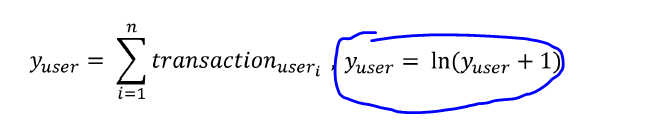

로그를 씌운 값을 예측하기 때문에 Y에 np.log1p 함수를 적용합니다.

In [6]:
Y = np.log1p(Y)

In [7]:
Y

0        17.449406
1        19.541283
2        18.035459
3        17.083177
4        20.168401
           ...    
11510    19.630417
11511    20.212357
11512    17.241401
11513    18.055253
11514    18.132865
Name: totals.transactionRevenue, Length: 11515, dtype: float64

In [8]:
seed = 42

RFR = RandomForestRegressor(random_state = seed)
SVR = SVR()

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [9]:
#cross_score = cross_val_score(RFR, X, Y, cv = 10, scoring='neg_mean_squared_error')
#rmse_score = np.sqrt(-cross_score) 
#rmse_mean = rmse_score.mean() 
#rmse_std = rmse_score.std()

In [10]:
def cross_score(model):
    cross_scoree = cross_val_score(model, X, Y, cv = 10, scoring='neg_mean_squared_error')
    rmse_score = np.sqrt(-cross_scoree) 
    rmse_mean = rmse_score.mean() 
    rmse_std = rmse_score.std()
    return print(rmse_mean)

- 랜덤 포레스트

In [11]:
cross_score(RFR)

1.09026688144138


rmse 참고 : https://davinci-ai.tistory.com/18

- SVM

In [12]:
cross_score(SVR)

1.1194813536215542


- 라잇 지비엠

In [13]:
from lightgbm.sklearn import LGBMRegressor

In [14]:
lgbmodel=LGBMRegressor(random_state= 42, learning_rate= 0.1, num_leaves= 30)

In [15]:
cross_score(lgbmodel)

1.0608532063605327


xgboost

In [16]:
from xgboost import XGBRegressor

In [17]:
XGB=XGBRegressor(objective='reg:squarederror', random_state= 42)

In [18]:
cross_score(XGB)

1.0620163626868024


### feature importance

In [253]:
features = X.columns.values

In [254]:
features

array(['channelGrouping', 'socialEngagementType', 'visitStartTime',
       'device.browser', 'device.operatingSystem', 'device.isMobile',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.visits', 'totals.newVisits',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.isTrueDirect', 'trafficSource.referralPath',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adContent', 'date', 'visitNumber', 'totals.hits',
       'totals.pageviews'], dtype=object)

In [20]:
from sklearn.model_selection import cross_validate


In [22]:
output = cross_validate(lgbmodel, X, Y, cv=10, scoring = 'neg_mean_squared_error', return_estimator =True)


In [ ]:
output

In [ ]:
X

In [23]:
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns.values,
                                        columns=['importance']).sort_values('importance', ascending=False)
    FI=feature_importances

Features sorted by their score for estimator 0:
Features sorted by their score for estimator 1:
Features sorted by their score for estimator 2:
Features sorted by their score for estimator 3:
Features sorted by their score for estimator 4:
Features sorted by their score for estimator 5:
Features sorted by their score for estimator 6:
Features sorted by their score for estimator 7:
Features sorted by their score for estimator 8:
Features sorted by their score for estimator 9:


https://www.kaggle.com/codename007/home-credit-complete-eda-feature-importance#7.-Feature-Importance-using-Random-forest

In [24]:
FI

,importance
totals.hits,396
visitNumber,323
totals.pageviews,311
visitStartTime,287
date,263
geoNetwork.networkDomain,250
geoNetwork.city,185
device.operatingSystem,165
geoNetwork.metro,109
trafficSource.source,106


----

In [68]:
import matplotlib.pyplot as plt

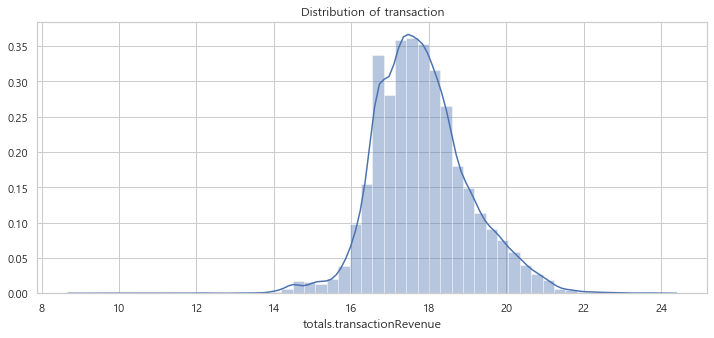

In [70]:
plt.figure(figsize=(12,5))
plt.title("Distribution of transaction")
ax = sns.distplot(Y)

---

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html

---

아저씨 점수

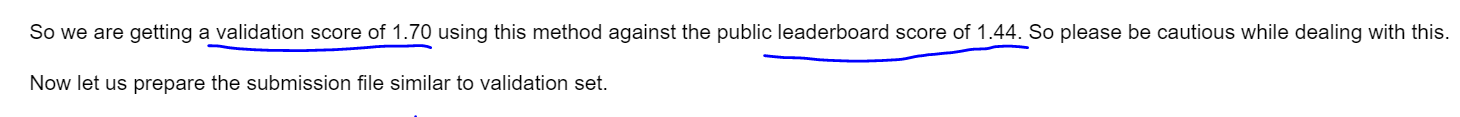

---